In [1]:
import os
import cv2
import pickle 
import numpy as np
import tensorflow as tf
from keras import regularizers
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.layers import Dense , Flatten , BatchNormalization , Dropout , Conv2D , MaxPooling2D 

2024-02-04 22:10:21.980091: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-04 22:10:23.470383: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
tf.config.list_physical_devices('GPU')

2024-02-04 22:10:26.992664: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-04 22:10:27.359789: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-04 22:10:27.360325: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# main_directory/
#     class_1/
#         img_1.jpg
#         img_2.jpg
#     class_2/
#         img_1.jpg
#         img_2.jpg


train = tf.keras.utils.image_dataset_from_directory(
    directory='Data/train',
    validation_split=0.2,
    subset="training",
    batch_size=16,
    image_size=(420,420),
    seed=128
)

test = tf.keras.utils.image_dataset_from_directory(
    directory='Data/test',
    validation_split=0.2,
    subset="training",
    batch_size=16,
    image_size=(420,420),
    seed=128
)

Found 66049 files belonging to 7 classes.
Using 52840 files for training.


2024-02-04 22:12:02.889844: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-04 22:12:02.890153: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-04 22:12:02.890370: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-04 22:12:03.038730: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-04 22:12:03.039090: I tensorflow/compile

Found 1750 files belonging to 7 classes.
Using 1400 files for training.


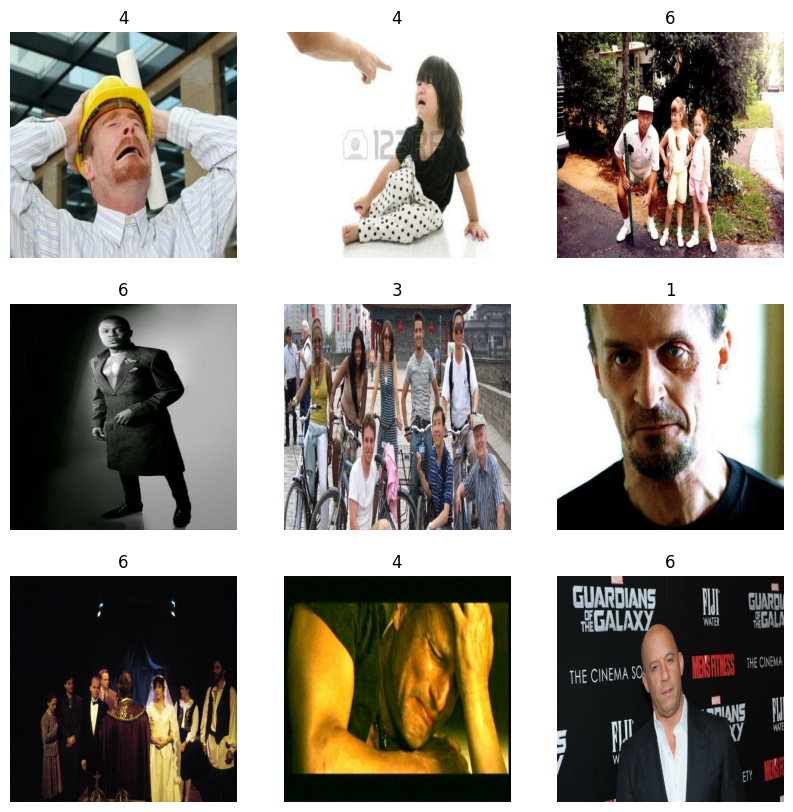

In [4]:
class_names = train.class_names
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:
def Normalize(image , label):
    image = tf.cast(image/255 , tf.float32)
    return image , label 

train_ds = train.map(Normalize)    
test_ds = test.map(Normalize)

In [6]:
conv_base = VGG16(
    weights='imagenet',
    include_top = False,
    input_shape=(420,420,3)
)

In [7]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block4_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in conv_base.layers:
  print(layer.name,layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 True
block4_conv2 True
block4_conv3 True
block4_pool True
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [8]:
model = Sequential()

model.add(conv_base)

model.add(Flatten())

model.add(Dense(128,activation='relu', kernel_regularizer=regularizers.l2(0.05)))
model.add(Dense(94,activation='relu' , kernel_regularizer=regularizers.l1(0.06)))
model.add(BatchNormalization())
model.add(Dense(64,activation='relu' ))
model.add(Dense(64,activation='relu' ))
model.add(BatchNormalization())
model.add(Dense(64,activation='relu' ))
model.add(Dense(64,activation='relu' ))
model.add(BatchNormalization())
model.add(Dense(32,activation='relu' ))
model.add(Dense(32,activation='relu' ))

model.add(Dense(7 , activation='softmax'))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 13, 13, 512)       14714688  
                                                                 
 flatten (Flatten)           (None, 86528)             0         
                                                                 
 dense (Dense)               (None, 128)               11075712  
                                                                 
 dense_1 (Dense)             (None, 94)                12126     
                                                                 
 batch_normalization (Batch  (None, 94)                376       
 Normalization)                                                  
                                                                 
 dense_2 (Dense)             (None, 64)                6080      
                                                        

In [10]:
model.compile(optimizer='Adam' , loss='categorical_crossentropy' , metrics=['accuracy'])

In [11]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'


In [12]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds, epochs=50, validation_data= test_ds )


3303/3303 [==============================] - 625s 186ms/step - loss: 4.4021 - accuracy: 0.3749 - val_loss: 3.9109 - val_accuracy: 0.1421
Epoch 2/50
3303/3303 [==============================] - 612s 185ms/step - loss: 2.4625 - accuracy: 0.3841 - val_loss: 2.7657 - val_accuracy: 0.1436
Epoch 3/50
3303/3303 [==============================] - 613s 185ms/step - loss: 2.1950 - accuracy: 0.3840 - val_loss: 3.5257 - val_accuracy: 0.1464
Epoch 4/50
3303/3303 [==============================] - 611s 185ms/step - loss: 2.1264 - accuracy: 0.3850 - val_loss: 2.9699 - val_accuracy: 0.1821
Epoch 5/50
3303/3303 [==============================] - 609s 184ms/step - loss: 2.1554 - accuracy: 0.3908 - val_loss: 2.9631 - val_accuracy: 0.2021
Epoch 6/50
3303/3303 [==============================] - 633s 191ms/step - loss: 2.3431 - accuracy: 0.4462 - val_loss: 2.8775 - val_accuracy: 0.2693
Epoch 7/50
3303/3303 [==============================] - 613s 185ms/step - loss: 2.2147 - accuracy: 0.4794 - val_loss: 3.221

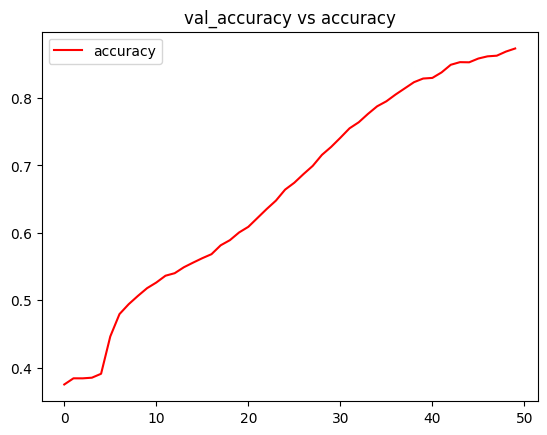

In [16]:
plt.plot(history.history['accuracy'] , 'red' ,label='accuracy')
plt.title('val_accuracy vs accuracy')
plt.legend()

In [14]:
pickle.dump(model , open('mode_vgg_update.pkl' , 'wb'))

In [28]:
model = pickle.load( open('mode_vgg_update.pkl' , 'rb'))

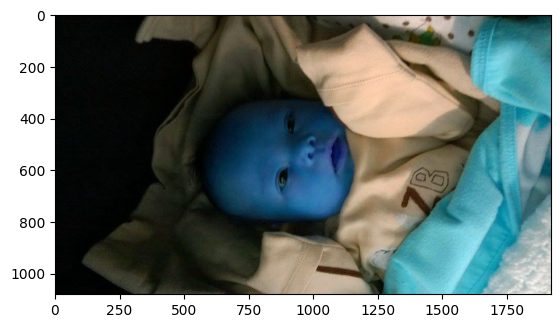

In [38]:
Image = cv2.imread('heartbroken_infant_714.jpg')
plt.imshow(Image)

In [39]:
Image = cv2.resize(Image,(420,420))
output = model.predict(Image.reshape((1,420,420,3)))
output

1/1 [==============================] - 0s 25ms/step


array([[1.3348584e-09, 1.2661640e-16, 5.2862994e-09, 3.9658328e-08,
        9.7030565e-13, 1.0000000e+00, 2.1899981e-16]], dtype=float32)

In [40]:
output.max()

1.0

In [41]:
decode = {
    0 : "angry",
    1 : "disgust",
    2 : "fear",
    3 : "happy",
    4 : "sad",
    5 : "surprise",
    6 : "neutral",
}
for key , value in decode.items():
    if np.where(output==output.max())[1] == key:
        print(value)

surprise
